In [1]:
from cobra.io import read_sbml_model
from collections import defaultdict
from Bio import Entrez, SeqIO
import re
import time

model = read_sbml_model('iCGB21FR.xml')

SBML package 'layout' not supported by cobrapy, information is not parsed
https://juser.fz-juelich.de/record/188973 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


The issue with the model "iCGB21FR.xml" is that its authors have named the genes in the following format **"lcl_{locus}_prot_{protein_id}_{unknown_digits}"**. An exemple name of the genes from the model would look like this: lcl_NC_006958_1_prot_WP_003859586_1_2138

In which **"NC_006958"** is the locus represent the complete sequence of Corynebacterium glutamicum ATCC 13032, and **WP_XXXXXXXXX** represent the protein_id of its genes.


**This results in adding an extra step of finding the gene name for the concerned protein ids.**


# Mapping:
- reaction -> genes
- gene -> reactions

In [2]:
print(f"{len(model.reactions)} reactions in 'iCGB21FR' model")
print(f"{len(model.genes)} genes in 'iCGB21FR' model")

1539 reactions in 'iCGB21FR' model
805 genes in 'iCGB21FR' model


In [3]:
reaction_to_genes = {}
gene_to_reactions = {}

def mapReactionToGenes():    
    for reaction in model.reactions:
        gene_ids = []
        for gene in reaction.genes:
            gene_ids.append(gene.id)
            
        reaction_to_genes[reaction.id] = gene_ids

def mapGeneToReactions():
    for reaction_id, gene_ids in reaction_to_genes.items():
        for gene_id in gene_ids:
            if gene_id:
                if gene_id not in gene_to_reactions:
                    gene_to_reactions[gene_id] = [reaction_id]
                else:
                    gene_to_reactions[gene_id].append(reaction_id)
    
mapReactionToGenes()
mapGeneToReactions()

In [4]:
print(f"{len(reaction_to_genes)} reactions are mapped in total")

reactions_coded_by_genes = 0
for reaction, genes in list(reaction_to_genes.items()):
    if len(genes) > 0:
        reactions_coded_by_genes +=1
print(f"{reactions_coded_by_genes} reactions have a genetic component (coded by at least one gene)\n")

print("   ...")
for reaction, genes in list(reaction_to_genes.items())[15:25]:
    print(f"{reaction} -> ")
    for gene in genes:
        print(f"    {gene}")
print("   ...")

1539 reactions are mapped in total
1077 reactions have a genetic component (coded by at least one gene)

   ...
2AGPG141tipp -> 
2AGPGAT141 -> 
2HH24DDH -> 
2MAHMP -> 
    lcl_NC_006958_1_prot_WP_003855288_1_2949
    lcl_NC_006958_1_prot_WP_011015468_1_2761
2PGLYCt6 -> 
3HAD140 -> 
3MBt2pp -> 
    lcl_NC_006958_1_prot_WP_011013917_1_810
3MBt4pp -> 
    lcl_NC_006958_1_prot_WP_011013917_1_810
3MBtex -> 
3OADPCOAT -> 
   ...


In [5]:
print(f"\n{len(gene_to_reactions)} genes are mapped in total\n")

for gene, reactions in list(gene_to_reactions.items())[:5]:
    print(f"{gene} ->")
    for reaction in reactions:
        print(f"    {reaction}")
print("   ...")


805 genes are mapped in total

lcl_NC_006958_1_prot_WP_003855288_1_2949 ->
    2MAHMP
    TDP
lcl_NC_006958_1_prot_WP_011015468_1_2761 ->
    2MAHMP
    PDXPP
    PYDXPP
lcl_NC_006958_1_prot_WP_011013917_1_810 ->
    3MBt2pp
    3MBt4pp
    ACt2rpp
    ACt4pp
    BUTt2rpp
    BUTt4pp
    GLYCLTt4pp
    PACt3
    PNTOt2
    PPAt2pp
    PPAt4pp
    PYRt2rpp
    PYRt4pp
lcl_NC_006958_1_prot_WP_003859251_1_2275 ->
    3OXCOAT
    ACACT1r
    ACACT2r
lcl_NC_006958_1_prot_WP_011015386_1_2669 ->
    4ABUTD
    ALDD2x
    ALDD2y
    ALDD31
    ALDD3y
    GLXO1
    GLYALDDr
    LCADi
   ...


In [6]:
gene_to_reactions_counts = defaultdict(list)

for gene, reactions in gene_to_reactions.items():
    gene_to_reactions_counts[len(reactions)].append((gene, reactions))

sorted_counts = sorted(gene_to_reactions_counts.items(), key=lambda x: x[0])

for count, gene_to_reactions_data in sorted_counts:
    reaction_str = "reaction" if count == 1 else "reactions"
    print(f"{len(gene_to_reactions_data)} genes control {count} {reaction_str}")

513 genes control 1 reaction
149 genes control 2 reactions
51 genes control 3 reactions
25 genes control 4 reactions
12 genes control 5 reactions
19 genes control 6 reactions
6 genes control 7 reactions
4 genes control 8 reactions
5 genes control 9 reactions
5 genes control 10 reactions
4 genes control 11 reactions
4 genes control 13 reactions
1 genes control 14 reactions
2 genes control 15 reactions
1 genes control 21 reactions
1 genes control 22 reactions
3 genes control 23 reactions


### Getting the gene data from the RefSeq database based on its protein ID

Fetching every protein Id in **gene_to_reactions** and returning the data for its gene: gene_name, product, organism, sequence.

The data is stored locally in **protein_id_to_gene_map** for future use, avoiding searching every time.

In [99]:
import re
from Bio import Entrez, SeqIO
import time
import json

def getProteinID(full_gene):
    """
    Function to get protein ID from a full gene name
    
    """
    return "WP_" + re.search(r"WP_(\d{9})", full_gene).group(1) if re.search(r"WP_(\d{9})", full_gene) else None


def fetchProteinID(protein_id, max_retries=50, delay_between_retries=1):
    """
    Function to fetch protein ID data
    
    """
    for attempt in range(max_retries):
        try:
            Entrez.email = "h.bensaadi@gmail.com"

            handle = Entrez.efetch(db="protein", id=protein_id, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            handle.close()

            gene_name, product, organism, sequence = None, None, None, None

            for feature in record.features:
                if 'gene' in feature.qualifiers:
                    gene_name = feature.qualifiers['gene'][0]
                if 'product' in feature.qualifiers:
                    product = feature.qualifiers['product'][0]
                if 'organism' in feature.qualifiers:
                    organism = feature.qualifiers['organism'][0]

            sequence = str(record.seq)

            return protein_id, gene_name, product, organism, sequence

        except Entrez.HTTPError as e:
            if attempt < max_retries - 1:
                print(f"{protein_id}: retrying in {delay_between_retries} seconds...")
                time.sleep(delay_between_retries)
            else:
                print(f"Max retries reached. Unable to fetch data for {protein_id}")
                raise
        except Exception as e:
            print(f"Error: {e}")
            raise

def loadMapFile():
    try:
        with open("protein_id_to_gene_map.json", "r") as file:
            protein_id_to_gene_map = json.load(file)
    except FileNotFoundError:
        protein_id_to_gene_map = {}
    
    return protein_id_to_gene_map
    
def updateMapFile(protein_id_to_gene_map):
    with open("protein_id_to_gene_map.json", "w") as file:
        json.dump(protein_id_to_gene_map, file)
            
def mapProteinIDtoGene():
    protein_id_to_gene_map = loadMapFile()
    count_found_genes = 0

    print(f"{len(list(gene_to_reactions.items()))} protein ids to fetch its data")

    for gene, reactions in list(gene_to_reactions.items()):
        if "WP_" in gene:
            protein_id = getProteinID(gene)

            if protein_id not in protein_id_to_gene_map:
                protein_id, gene_name, product, organism, sequence = fetchProteinID(protein_id)
                protein_id_to_gene_map[protein_id] = [gene_name, product, organism, sequence]
                
                updateMapFile(protein_id_to_gene_map)
                
                print(f"\n{protein_id}, {gene_name}, {product}, {organism}, {sequence}")

    print(f"{count_found_genes} protein IDs were fetched")
    print(f"{len(protein_id_to_gene_map)} protein IDs are stored locally")
    
    
mapProteinIDtoGene()

for protein_id, protein_data in list(protein_id_to_gene_map.items())[21:23]:
    print(f"\n{protein_id} ->")
    gene_name, product, organism, sequence = protein_data
    print(f"    {gene_name}")
    print(f"    {product}")
    print(f"    {organism}")
    print(f"    {sequence[:70]}...")
print("   ...")

805 protein ids to fetch its data
0 protein IDs were fetched
785 protein IDs are stored locally

WP_011014763 ->
    ptsP
    phosphoenolpyruvate--protein phosphotransferase
    Corynebacterium glutamicum
    MATVADVNQDTVLKGTGVVGGVRYASAVWITPRPELPQAGEVVAEENREAEQERFDAAAATVSSRLLERS...

WP_003858695 ->
    argB
    acetylglutamate kinase
    Corynebacterium
    MNDLIKDLGSEVRANVLAEALPWLQHFRDKIVVVKYGGNAMVDDDLKAAFAADMVFLRTVGAKPVVVHGG...
   ...


### Serching the protein ID of a known gene 
The locally stored **protein_id_to_gene_map** is used to search for the **gene name** or its **sequence**

In [74]:
def searchGene(gene=None, seq=None):
    matches = []
    
    protein_id_to_gene_map = loadMapFile()

    for protein_id, data in protein_id_to_gene_map.items():
        gene_name, product, organism, sequence = data
        
        if (gene and gene_name and gene.lower() in gene_name.lower()) or (sequence and seq and sequence.lower() in seq.lower()):
            matches.append((protein_id, data))

    return matches

In [100]:
searchGene(gene="argB")

[('WP_003858695',
  ['argB',
   'acetylglutamate kinase',
   'Corynebacterium',
   'MNDLIKDLGSEVRANVLAEALPWLQHFRDKIVVVKYGGNAMVDDDLKAAFAADMVFLRTVGAKPVVVHGGGPQISEMLNRVGLQGEFKGGFRVTTPEVMDIVRMVLFGQVGRDLVGLINSHGPYAVGTSGEDAGLFTAQKRMVNIDGVPTDIGLVGDIINVDASSLMDIIEAGRIPVVSTIAPGEDGQIYNINADTAAGALAAAIGAERLLVLTNVEGLYTDWPDKSSLVSKIKATELEAILPGLDSGMIPKMESCLNAVRGGVSAAHVIDGRIAHSVLLELLTMGGIGTMVLPDVFDRENYPEGTVFRKDDKDGEL'])]

In [102]:
searchGene(seq="MNDLIKDLGSEVRANVLAEALPWLQHFRDKIVVVKYGGNAMVDDDLKAAFAADMVFLRTVGAKPVVVHGGGPQISEMLNRVGLQGEFKGGFRVTTPEVMDIVRMVLFGQVGRDLVGLINSHGPYAVGTSGEDAGLFTAQKRMVNIDGVPTDIGLVGDIINVDASSLMDIIEAGRIPVVSTIAPGEDGQIYNINADTAAGALAAAIGAERLLVLTNVEGLYTDWPDKSSLVSKIKATELEAILPGLDSGMIPKMESCLNAVRGGVSAAHVIDGRIAHSVLLELLTMGGIGTMVLPDVFDRENYPEGTVFRKDDKDGEL")

[('WP_003858695',
  ['argB',
   'acetylglutamate kinase',
   'Corynebacterium',
   'MNDLIKDLGSEVRANVLAEALPWLQHFRDKIVVVKYGGNAMVDDDLKAAFAADMVFLRTVGAKPVVVHGGGPQISEMLNRVGLQGEFKGGFRVTTPEVMDIVRMVLFGQVGRDLVGLINSHGPYAVGTSGEDAGLFTAQKRMVNIDGVPTDIGLVGDIINVDASSLMDIIEAGRIPVVSTIAPGEDGQIYNINADTAAGALAAAIGAERLLVLTNVEGLYTDWPDKSSLVSKIKATELEAILPGLDSGMIPKMESCLNAVRGGVSAAHVIDGRIAHSVLLELLTMGGIGTMVLPDVFDRENYPEGTVFRKDDKDGEL'])]

## Gene knockout:

Replicating the knockout of 4 genes from https://link.springer.com/article/10.1007/s00726-020-02893-6 
- gluE
- brnE
- brnF
- lysP

In [101]:
genes = ["gluE", "brnE", "brnF", "lysP"]

for gene in genes:
    print(gene)
    print(searchGene(gene))

gluE
[]
brnE
[]
brnF
[]
lysP
[]


## Cobra part

In [12]:
genes = {"gluE":"",
         "brnE":["cg0315", "MTTDFSCILLVVAVCAVITFALRAVPFLILKPLRESQFVGKMAMWMPAGILAILTASTFRSNAIDLKTLTFGLIAVAITVVAHLLGGRRTLLSVGAGTIVFVGLVNLF"],
         "brnF":"cg0314",
         "lysP":""
        }

In [13]:
genes["brnE"]

['cg0315',
 'MTTDFSCILLVVAVCAVITFALRAVPFLILKPLRESQFVGKMAMWMPAGILAILTASTFRSNAIDLKTLTFGLIAVAITVVAHLLGGRRTLLSVGAGTIVFVGLVNLF']

In [14]:
model.reactions.get_by_id("AIRCr")

Reaction identifier,AIRCr
Name,Phosphoribosylaminoimidazole carboxylase
Memory address,0x1d07e9e87f0
Stoichiometry,air_c + co2_c <=> 5aizc_c + h_c 5-amino-1-(5-phospho-D-ribosyl)imidazole + CO2 <=> 5-amino-1-(5-phospho-D-ribosyl)imidazole-4-carboxylate + H+
GPR,lcl_NC_006958_1_prot_WP_003858249_1_691 or (lcl_NC_006958_1_prot_WP_003858249_1_691 and...
Lower bound,-1000.0
Upper bound,1000.0


In [15]:
model.genes.get_by_id("lcl_NC_006958_1_prot_WP_011265608_1_688")


Gene identifier,lcl_NC_006958_1_prot_WP_011265608_1_688
Name,G_lcl_NC_006958_1_prot_WP_011265608_1_688
Memory address,0x1d07e7cdeb0
Functional,True
In 1 reaction(s),AIRCr


In [16]:
import cobra
from cobra.io import read_sbml_model
from cobra.flux_analysis import single_gene_deletion, double_gene_deletion, double_reaction_deletion


# OptKnock
gene_knockout_result = single_gene_deletion(model)
gene_knockout_result


,ids,growth,status
0,{lcl_NC_006958_1_prot_WP_011014798_1_1876},0.000000e+00,optimal
1,{lcl_NC_006958_1_prot_WP_011013607_1_363},5.706601e-01,optimal
2,{WP_011013606_1},5.706601e-01,optimal
3,{lcl_NC_006958_1_prot_WP_011013454_1_184},5.706601e-01,optimal
4,{lcl_NC_006958_1_prot_WP_011015000_1_2155},-5.440447e-16,optimal
...,...,...,...
800,{lcl_NC_006958_1_prot_WP_003862124_1_1046},5.706601e-01,optimal
801,{lcl_NC_006958_1_prot_WP_003862609_1_2768},1.528081e-16,optimal
802,{lcl_NC_006958_1_prot_WP_011013914_1_806},5.706601e-01,optimal
803,{lcl_NC_006958_1_prot_WP_011013674_1_459},5.706601e-01,optimal


In [17]:
optknock_genes = cobra.flux_analysis.find_gene_knockout_strategies(gene_knockout_result)

AttributeError: module 'cobra.flux_analysis' has no attribute 'find_gene_knockout_strategies'

In [ ]:
# Example: Double Gene Deletion (OptGene-like)
double_gene_knockout_result = double_gene_deletion(model)
optgene_genes = cobra.flux_analysis.find_gene_knockout_strategies(double_gene_knockout_result)

# Example: Double Reaction Deletion (OptCouple-like)
double_reaction_knockout_result = double_reaction_deletion(model)
optcouple_genes = cobra.flux_analysis.find_gene_knockout_strategies(double_reaction_knockout_result)

# Display the results
print("OptKnock Genes:", optknock_genes)
print("OptGene-like Genes:", optgene_genes)
print("OptCouple-like Genes:", optcouple_genes)


In [ ]:
print('complete model: ', model.optimize())
with model:
    model.reactions.PFK.knock_out()
    print('pfk knocked out: ', model.optimize())

In [ ]:
for metabolite in model.genes.query('brnEF', 'name'):
    print(metabolite.name)

In [ ]:
def searchGeneName(gene_query):
    for gene in model.genes:
        if "kegg.genes" in gene.annotation:
            if gene_query in gene.annotation["kegg.genes"]:
                print(gene.id)
                print(gene.annotation)
                break
            else:
                print(f"{gene_query} not found")
                break


In [ ]:
searchGeneName("cg0314")

In [ ]:
searchGeneName("cg0315")

In [ ]:
model.genes[0].reactions

In [ ]:
reaction = model.reactions.query('2MAHMP')
reaction

In [ ]:
model.reactions[250].genes

In [ ]:
len("MKKRINVTGAVLVKENRILAAQRGPEMSLPGYWEFPGGKIEQGETPEASLARELKEELLCDATVGEHLTTTEHEYDFGIVVLSTYFCTLNDAEPQLTEHAEIRWVAPHELESLEWAPADIPAVKLLVEQLA")

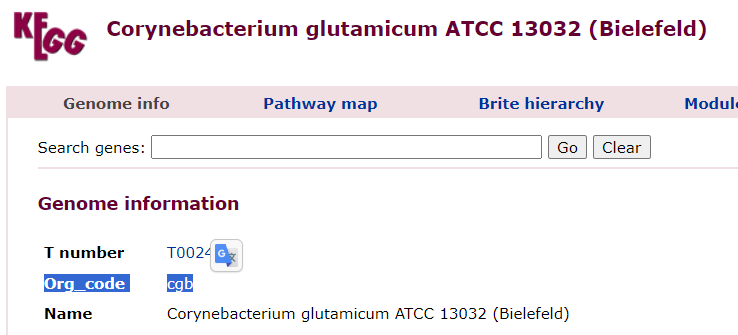

In [ ]:
from bioservices import KEGG

k = KEGG()
k.organism = "cgb"

pathwayIds = k.pathwayIds
enzymeIds = k.enzymeIds
compoundIds = k.compoundIds

In [ ]:
s = KEGG()
data = s.get("cgb04660")
dict_data = s.parse(data)['GENE']
type(dict_data)
